Find cells belonging to different clusters in the same field of view. Draw contour of cells.

In [1]:
from tifffile import imread
from skimage.measure import find_contours, regionprops
from matplotlib import pyplot as plt
import seaborn as sns
import os, sys
from starmap.sequencing import *
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# ppath = '/stanley/WangLab/Data/Processed/2022-09-30-Rena-Cardiomyocyte64Gene'
ppath = 'Z:/Data/Processed/2022-10-15-Rena-SkinCulture254-gene'

In [3]:
def load_reads_3D(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 2]-1)
    temp[:, 1] = np.round(points[:, 1]-1)
    temp[:, 2] = np.round(points[:, 0]-1)

    print(f"Number of reads: {len(bases)}")
    return bases, temp

In [4]:
area_list = list(range(1,7))
area2sample = {
    1: '2h_labeling',
    2: '2h_labeling_2h_wash',
    3: '2h_labeling_4h_wash',
    4: '20h_labeling', 
    5: '2h_labeling_6h_wash', 
    6: 'STARmap'
}

In [5]:
# add cell label
cell_type = pd.read_csv('Z:/Connie/02.TEMPOmap/04.revisionForeskin254Gene/Nov16_skin_cluster_label_fixed.csv')
cell_type

Unnamed: 0  orig_index               sample     area      x      y   z  \
0              0           0          2h_labeling   275680     63   6724  22   
1              1           1          2h_labeling   280621     63   3816  18   
2              3           3          2h_labeling   771134    121   9836  19   
3              4           4          2h_labeling  1205013    146   5887  27   
4              5           5          2h_labeling  1720379    164  13669  22   
...          ...         ...                  ...      ...    ...    ...  ..   
8020       10492        1660  2h_labeling_6h_wash   662891  16451   2600  12   
8021       10493        1661  2h_labeling_6h_wash   447258  16445   5293  11   
8022       10494        1662  2h_labeling_6h_wash   924337  16376   6623  12   
8023       10495        1663  2h_labeling_6h_wash   647931  16445  14103  11   
8024       10496        1664  2h_labeling_6h_wash   776318  16568  13954  11   

      nuclues_volume  AF546  AF546_nucleus  n_genes_by_counts  \
0             140797      0              0                 87   
1              46370      0              0                 64   
2             191065      1              0                142   
3             164774      0              0                 68   
4             295120      1              0                122   
...              ...    ...            ...                ...   
8020          265923      3              1                 50   
8021          210822      1              1                 46   
8022          247604      1              0                 72   
8023          254868      0              0                 56   
8024          328797      0              0                 62   

      log1p_n_genes_by_counts  total_counts  log1p_total_counts   volume  \
0                    4.477337           146            4.990433   275680   
1                    4.174387           121            4.804021   280621   
2                    4.962845           486            6.188264   771134   
3                    4.234107           141            4.955827  1205013   
4                    4.812184           642            6.466145  1720379   
...                       ...           ...                 ...      ...   
8020                 3.931826           109            4.700480   662891   
8021                 3.850148            75            4.330733   447258   
8022                 4.290459           178            5.187386   924337   
8023                 4.043051           120            4.795791   647931   
8024                 4.143135           170            5.141664   776318   

      n_volume  nCount_RNA  nFeature_RNA  RNA_snn_res.0.08  seurat_clusters  
0       140797         146            87                 2                2  
1        46370         121            64                 1                1  
2       191065         486           142                 1                1  
3       164774         141            68                 2                2  
4       295120         642           122                 2                2  
...        ...         ...           ...               ...              ...  
8020    265923         109            50                 0                0  
8021    210822          75            46                 0                0  
8022    247604         178            72                 0                0  
8023    254868         120            56                 0                0  
8024    328797         170            62                 0                0  

[8025 rows x 20 columns]

In [6]:
np.unique(cell_type['sample'])

array(['2h_labeling', '2h_labeling_2h_wash', '2h_labeling_4h_wash',
       '2h_labeling_6h_wash'], dtype=object)

Number of reads: 893831


100%|██████████| 336/336 [07:18<00:00,  1.30s/it]


Number of reads: 990123


100%|██████████| 439/439 [09:39<00:00,  1.32s/it]


Number of reads: 628307


100%|██████████| 488/488 [10:38<00:00,  1.31s/it]


Number of reads: 480138


100%|██████████| 259/259 [05:42<00:00,  1.32s/it]


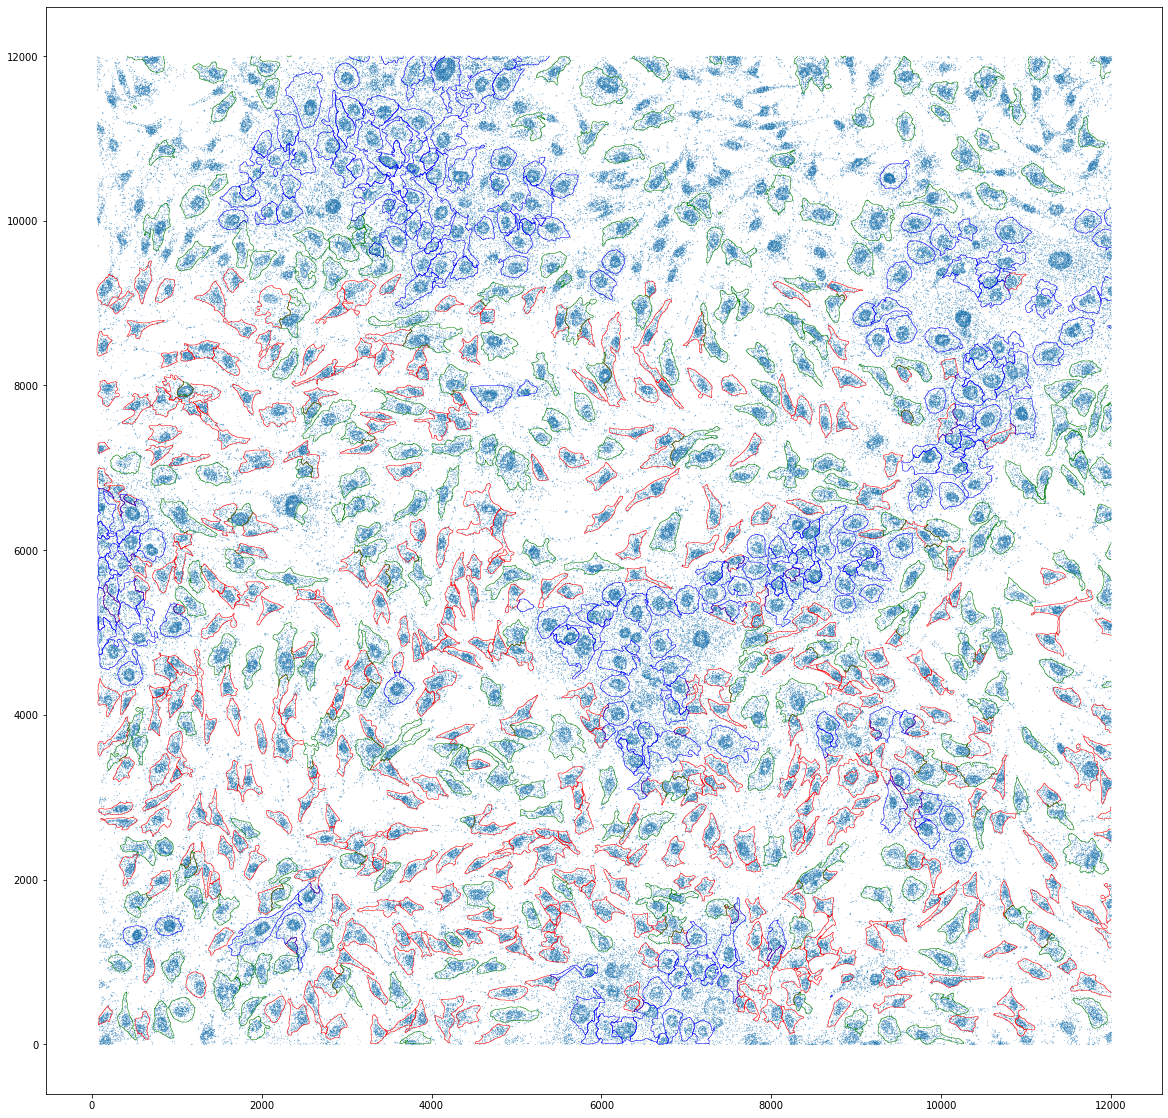

In [10]:
ub = 12000
for area in [1,2,3,5]:
    # reads -> project to 2D
    genes2seqs, seqs2genes = load_genes(ppath)
    mat_bases, mat_points = load_reads_3D(os.path.join(ppath, 'output', '2022-11-07-merged-points', f'Area{area}'), 'merged_goodPoints.mat')
    points = mat_points.astype(int)
    bases = np.array([seqs2genes[x] for x in mat_bases])
    # cell type 
    _cell_type = cell_type[cell_type['sample']==area2sample[area]]
    melanocyte = _cell_type[_cell_type['seurat_clusters']==0]['orig_index']+1
    fibroblast = _cell_type[_cell_type['seurat_clusters']==1]['orig_index']+1
    keratinocyte = _cell_type[_cell_type['seurat_clusters']==2]['orig_index']+1
    # segmentation
    cell_seg = imread(os.path.join(ppath, 'output', '2022-11-07-2D-segmentation', 'flamingo_backscaled', f'Area{area}_cell_2D.tif'))
    _cell_seg = cell_seg[:ub, :ub] 

    # contour   
    contour_melanocyte = []
    for i in tqdm(melanocyte[:500]):
        ct = find_contours(_cell_seg==i)
        if len(ct):
            contour_melanocyte.append(ct[0])
    contour_fibroblast = []
    for i in tqdm(fibroblast[:500]):
        ct = find_contours(_cell_seg==i)
        if len(ct):
            contour_fibroblast.append(ct[0])
    contour_keratinocyte = []
    for i in tqdm(keratinocyte[:500]):
        ct = find_contours(_cell_seg==i)
        if len(ct):
            contour_keratinocyte.append(ct[0])
    # points
    _points = points[np.logical_and(points[:,1]<ub, points[:,2]<ub)]
    plt.figure(figsize=(20,20))
    plt.scatter(_points[:,2], _points[:,1], s=0.01)
    for ct_melanocyte in contour_melanocyte:
        plt.plot(ct_melanocyte[:,1], ct_melanocyte[:,0], linewidth=0.5, c='red')
    for ct_fibroblast in contour_fibroblast:
        plt.plot(ct_fibroblast[:,1], ct_fibroblast[:,0], linewidth=0.5, c='green')
    for ct_keratinocyte in contour_keratinocyte:
        plt.plot(ct_keratinocyte[:,1], ct_keratinocyte[:,0], linewidth=0.5, c='blue')
    plt.savefig(f'Z:/Connie/02.TEMPOmap/04.revisionForeskin254Gene/output/figures/cell_contour_{area2sample[area]}.pdf')